- `TODO: adjust ...` 代表要改的

## Download Library

In [1]:
# !pip install ipykernel
# !pip install torch torchvision torchaudio
# !pip install matplotlib
# !pip install opencv-python

## import Library

In [2]:
from typing import Callable, Optional
from pathlib import Path

from PIL import Image
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

## MNIST

## Data Structure

```text
.
├── dataset
│   └── mnist
│       └── train
│           ├── data
│           │   ├── 0.jpg
│           │   ├── 1.jpg
│           │   ├── ...
│           │   └── 59999.jpg
│           └── label.txt
└── mnist.ipynb  (訓練 MNIST)
```


### Implement dataset class

In [3]:
class MnistDataset(Dataset):
    def __init__(self, path: str='./dataset/mnist/train', data_transform: Optional[Callable]=None) -> None:
        super().__init__()
        self.dataset_path = Path(path)
        self.data_transform = data_transform
        self.image, self.label = self.read_dataset()

        assert len(self.image) == len(self.label)
        self.length = len(self.image)

    def read_dataset(self):  # TODO: adjust this function
        image = dict()
        for path in self.dataset_path.joinpath('data').glob('**/*'):
            if path.suffix in ['.jpg']:
                image[int(path.stem)] = np.array(Image.open(path).copy())

        with open(self.dataset_path.joinpath('label.txt'), mode='r') as f:
            label = f.read()
        label = [int(i) for i in list(label)]

        return image, label

    def __getitem__(self, index):
        image, label = self.image[index], self.label[index]
        if self.data_transform is not None:
            image = Image.fromarray(image)
            image = self.data_transform(image)

        return image, label

    def __len__(self):
        return self.length

### Implement model class

In [4]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, out_num=10):  # TODO: adjust out_num
        super(CNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=5, stride=1, padding=0) # out_shape=(16,24,24)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # out_shape=(16,12,12)

        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) # out_shape=(32,8,8)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # out_shape=(32,4,4)

        self.fc1 = nn.Linear(in_features=32 * 4 * 4, out_features=out_num)  # in_shape=(32*4*4)  # TODO: adjust in_features

    def forward(self, x):
        x = self.cnn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

### Define Parameters

In [5]:
device = 'cuda'
dataset_path = './dataset/mnist/train'  # TODO: adjust path
output_path = './model/mnist.pt'  # TODO: adjust path
epoch = 5  #疊帶次數
batch_size = 16 #多少張圖
learning_rate = 0.1 
img_size=(28, 28)  # TODO: adjust img_size

### Build
(1)model, (2)loss-function, (3)optimizer, (4)dataloader

In [6]:
# build model
model = CNN().to(device)
print(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

data_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),   # [0, 1]
    # transforms.Normalize((0.5), (0.5))  # [-1, 1]
])
dataset = MnistDataset(path=dataset_path, data_transform=data_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

cuda


In [7]:
def accuracy(pred: torch.Tensor, label: torch.Tensor):
    _, pred_label = pred.max(1)
    num_correct = (pred_label == label).sum().item()
    acc = num_correct / label.shape[0]
    return acc

### Training

In [8]:
metric = {'loss': [], 'acc': []}
for i_epoch in range(epoch):
    train_loss = []
    train_acc = []
    model.train(mode=True)
    for i_batch, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)

        pred = model.forward(image)  # inference

        loss = criterion(pred, label)  # calculate loss
        optimizer.zero_grad()  # reset gradient to zero
        loss.backward()  # calculate gradient
        optimizer.step()  # optimize weight (using gradient)

        train_loss += [loss.item()]
        train_acc += [accuracy(pred, label)]

    metric['loss'] += [sum(train_loss)/ len(dataloader)]
    metric['acc'] += [sum(train_acc)/ len(dataloader)]
    print(f'Epoch[{i_epoch+1}/{epoch}] loss: {metric["loss"][-1]}, acc: {metric["acc"][-1]}')

Epoch[1/5] loss: 0.12484252233723528, acc: 0.9600666666666666
Epoch[2/5] loss: 0.04582011810022426, acc: 0.9854833333333334
Epoch[3/5] loss: 0.03372866201682579, acc: 0.98935
Epoch[4/5] loss: 0.026939631766847258, acc: 0.9916166666666667
Epoch[5/5] loss: 0.022380970956768578, acc: 0.99255


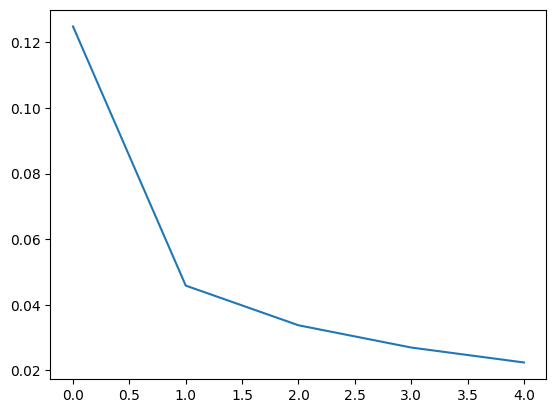

In [9]:
plt.plot(range(len(metric["loss"])), metric["loss"])

### Save Model

In [10]:
model_path = Path(output_path)
model_path.parent.mkdir(parents=True, exist_ok=True)
torch.jit.script(model).save(model_path)

### Load Model

In [11]:
model_path = Path('./model/mnist.pt')  # TODO: adjust path
assert model_path.exists() is True
image_path = Path('./dataset/mnist/test/data/0.jpg')  # TODO: adjust path
assert image_path.exists() is True

transform = transforms.Compose([
    transforms.Resize((28, 28)),  # TODO: adjust img_size
    transforms.ToTensor(),
])

trained_model = torch.jit.load(model_path)
test_image = Image.open(image_path)
trans_image = transform(test_image)
pred = trained_model(trans_image.unsqueeze(0))
pred_label = pred.max(1)[1]

print(pred_label)
test_image

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__.py", line 16, in forward
    x: Tensor) -> Tensor:
    cnn1 = self.cnn1
    x0 = (cnn1).forward(x, )
          ~~~~~~~~~~~~~ <--- HERE
    relu1 = self.relu1
    x1 = (relu1).forward(x0, )
  File "code/__torch__/torch/nn/modules/conv.py", line 23, in forward
    weight = self.weight
    bias = self.bias
    _0 = (self)._conv_forward(input, weight, bias, )
          ~~~~~~~~~~~~~~~~~~~ <--- HERE
    return _0
  def _conv_forward(self: __torch__.torch.nn.modules.conv.Conv2d,
  File "code/__torch__/torch/nn/modules/conv.py", line 29, in _conv_forward
    weight: Tensor,
    bias: Optional[Tensor]) -> Tensor:
    _1 = torch.conv2d(input, weight, bias, [1, 1], [0, 0], [1, 1])
         ~~~~~~~~~~~~ <--- HERE
    return _1

Traceback of TorchScript, original code (most recent call last):
  File "C:\Users\User\AppData\Local\Temp\ipykernel_12780\600151246.py", line 16, in forward
    def forward(self, x):
        x = self.cnn1(x)
            ~~~~~~~~~ <--- HERE
        x = self.relu1(x)
        x = self.maxpool1(x)
  File "c:\Users\User\anaconda3\envs\pytorch_project\lib\site-packages\torch\nn\modules\conv.py", line 458, in forward
    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)
               ~~~~~~~~~~~~~~~~~~ <--- HERE
  File "c:\Users\User\anaconda3\envs\pytorch_project\lib\site-packages\torch\nn\modules\conv.py", line 454, in _conv_forward
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
               ~~~~~~~~ <--- HERE
                        self.padding, self.dilation, self.groups)
RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
